In [1]:
# Mohammad Asif Zaman
# Original version: Oct 29, 2014


In [2]:
#%matplotlib inline
%matplotlib notebook                    

In [3]:
import time
import math
import numpy as np
import pylab as py

#import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
# initialization animation function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ttl.set_text('')
    
    return (line1,line2,ttl)

In [5]:
def force_es(r):
    F = np.zeros(2)
    Fmag = GG*Me*Ms/(np.linalg.norm(r)+1e-20)**2
    theta = math.atan(np.abs(r[1])/(np.abs(r[0])+1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]
        
    return F

def force_js(r):
    F = np.zeros(2)
    Fmag = GG*Mj*Ms/(np.linalg.norm(r)+1e-20)**2
    theta = math.atan(np.abs(r[1])/(np.abs(r[0])+1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]
        
    return F

def force_ej(re,rj):
    
    r = np.zeros(2)
    F = np.zeros(2)
    r[0] = re[0] - rj[0]    
    r[1] = re[1] - rj[1]    
    Fmag = GG*Me*Mj/(np.linalg.norm(r)+1e-20)**2
    theta = math.atan(np.abs(r[1])/(np.abs(r[0])+1e-20))
    F[0] = Fmag * np.cos(theta)
    F[1] = Fmag * np.sin(theta)
    if r[0] > 0:
        F[0] = -F[0]
    if r[1] > 0:
        F[1] = -F[1]
        
    return F


def force(r,planet,ro,vo):
    if planet == 'earth':
        return force_es(r) + force_ej(r,ro)
    if planet == 'jupiter':
        return force_js(r) - force_ej(r,ro)

    
def dr_dt(t,r,v,planet,ro,vo):
    return v
 
    
def dv_dt(t,r,v,planet,ro,vo):
    F = force(r,planet,ro,vo)
    if planet == 'earth':
        y = F/Me
    if planet == 'jupiter':
        y = F/Mj
    return y 

# Differential equation solvers
# ===================================================================
def EulerSolver(t,r,v,h):
    z = np.zeros([2,2])
    r1 = r + h*dr_dt(t,r,v)
    v1 = v + h*dv_dt(t,r,v)
    z = [r1, v1]
    return z

def EulerCromerSolver(t,r,v,h):
    z = np.zeros([2,2])
    r = r + h*dr_dt(t,r,v)
    v = v + h*dv_dt(t,r,v)
    z = [r, v]
    return z

def RK4Solver(t,r,v,h,planet,ro,vo):
    k11 = dr_dt(t,r,v,planet,ro,vo) 
    k21 = dv_dt(t,r,v,planet,ro,vo)
    
    k12 = dr_dt(t + 0.5*h,r + 0.5*h*k11,v + 0.5*h*k21,planet,ro,vo)
    k22 = dv_dt(t + 0.5*h,r + 0.5*h*k11,v + 0.5*h*k21,planet,ro,vo)
    
    k13 = dr_dt(t + 0.5*h,r + 0.5*h*k12,v + 0.5*h*k22,planet,ro,vo)
    k23 = dv_dt(t + 0.5*h,r + 0.5*h*k12,v + 0.5*h*k22,planet,ro,vo)
    
    k14 = dr_dt(t + h,r + h*k13,v + h*k23,planet,ro,vo)
    k24 = dv_dt(t + h,r + h*k13,v + h*k23,planet,ro,vo)
    
    y0 = r + h * (k11 + 2.*k12 + 2.*k13 + k14) / 6.
    y1 = v + h * (k21 + 2.*k22 + 2.*k23 + k24) / 6.
    
    z = np.zeros([2,2])
    z = [y0, y1]
    return z

# =====================================================================


def KineticEnergy(v):
    vn = np.linalg.norm(v)
    return 0.5*Me*vn**2

def PotentialEnergy(r):
    fmag = np.linalg.norm(force_es(r))
    rmag = np.linalg.norm(r)
    return -fmag*rmag

def AngMomentum(r,v):
    rn = np.linalg.norm(r)
    vn = np.linalg.norm(v)
    r = r/rn
    v = v/vn
    rdotv = r[0]*v[0]+r[1]*v[1]
    theta = math.acos(rdotv)
    return Me*rn*vn*np.sin(theta)

def AreaCalc(r1,r2):
    r1n = np.linalg.norm(r1)
    r2n = np.linalg.norm(r2)
    r1 = r1 + 1e-20
    r2 = r2 + 1e-20
    theta1 = math.atan(abs(r1[1]/r1[0]))
    theta2 = math.atan(abs(r2[1]/r2[0]))
    rn = 0.5*(r1n+r2n)
    del_theta = np.abs(theta1 - theta2)
    return 0.5*del_theta*rn**2

def mplot(fign,x,y,xl,yl,clr,lbl):
    py.figure(fign)
    py.xlabel(xl)    
    py.ylabel(yl)
    return py.plot(x,y,clr, linewidth =1.0,label = lbl)


In [6]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 29 09:51:10 2014

@author: Zaman
"""

Me = 6e24                     # Mass of Earth in kg
Ms = 2e30                     # Mass of Sun in kg                       
Mj = 1.9e27                   # Mass of Jupiter

G = 6.673e-11                 # Gravitational Constant

RR = 1.496e11                 # Normalizing distance in km (= 1 AU)
MM = 6e24                     # Normalizing mass
TT = 365*24*60*60.0           # Normalizing time (1 year)

FF = (G*MM**2)/RR**2          # Unit force
EE = FF*RR                    # Unit energy

GG = (MM*G*TT**2)/(RR**3)

Me = Me/MM                    # Normalized mass of Earth
Ms = Ms/MM                    # Normalized mass of Sun  
Mj = 500*Mj/MM                # Normalized mass of Jupiter/Super Jupiter


ti = 0                # initial time = 0
tf = 120              # final time = 120 years

 



N = 100*tf                   # 100 points per year
t = np.linspace(ti,tf,N)     # time array from ti to tf with N points 

h = t[2]-t[1]                # time step (uniform)


# Initialization

KE = np.zeros(N)            # Kinetic energy
PE = np.zeros(N)            # Potential energy
AM = np.zeros(N)            # Angular momentum
AreaVal = np.zeros(N)

r = np.zeros([N,2])         # position vector of Earth
v = np.zeros([N,2])         # velocity vector of Earth
rj = np.zeros([N,2])        # position vector of Jupiter
vj = np.zeros([N,2])        # velocity vector of Jupiter

ri = [1496e8/RR,0]      # initial position of earth
rji = [5.2,0]           # initial position of Jupiter




vv = np.sqrt(Ms*GG/ri[0])         # Magnitude of Earth's initial velocity 

vvj = 13.06e3 * TT/RR             # Magnitude of Jupiter's initial velocity 

vi = [0, vv*1.0]                  # Initial velocity vector for Earth.Taken to be along y direction as ri is on x axis.
vji = [0, vvj*1.0]                # Initial velocity vector for Jupiter


# Initializing the arrays with initial values.
t[0] = ti
r[0,:] = ri
v[0,:] = vi
rj[0,:] = rji
vj[0,:] = vji

"""
t1 = dr_dt(ti,ri,vi)
t2 = dv_dt(ti,ri,vi)
print t1
print t2
"""
KE[0] = KineticEnergy(v[0,:])
PE[0] = PotentialEnergy(r[0,:])
AM[0] = AngMomentum(r[0,:],v[0,:])
AreaVal[0] = 0


 


In [7]:
for i in range(0,N-1):
    [r[i+1,:],v[i+1,:]]=RK4Solver(t[i],r[i,:],v[i,:],h,'earth',rj[i,:],vj[i,:])
    [rj[i+1,:],vj[i+1,:]]=RK4Solver(t[i],rj[i,:],vj[i,:],h,'jupiter',r[i,:],v[i,:])
        
    KE[i+1] = KineticEnergy(v[i+1,:])
    PE[i+1] = PotentialEnergy(r[i+1,:])
    AM[i+1] = AngMomentum(r[i+1,:],v[i+1,:])
    AreaVal[i+1] = AreaVal[i] + AreaCalc(r[i,:],r[i+1,:])
    


<IPython.core.display.Javascript object>


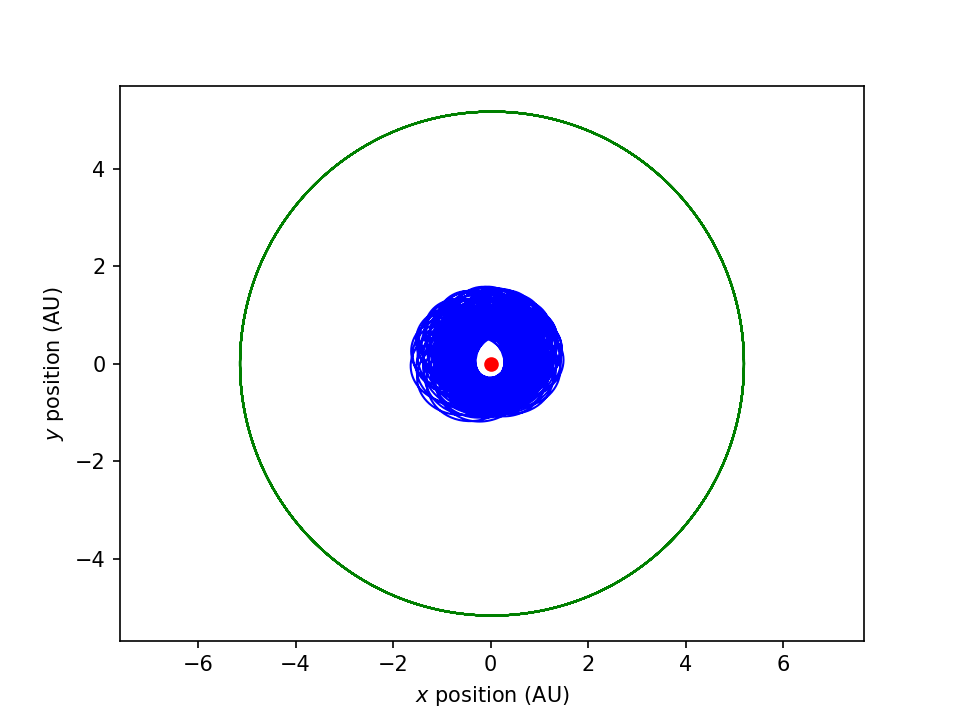

<IPython.core.display.Javascript object>


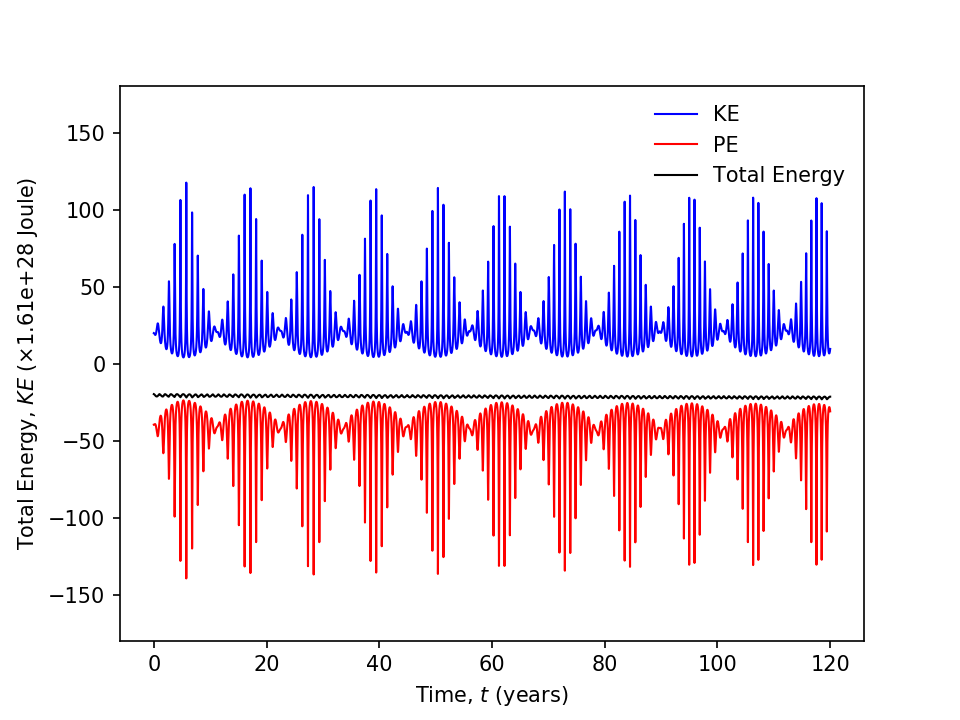

<IPython.core.display.Javascript object>


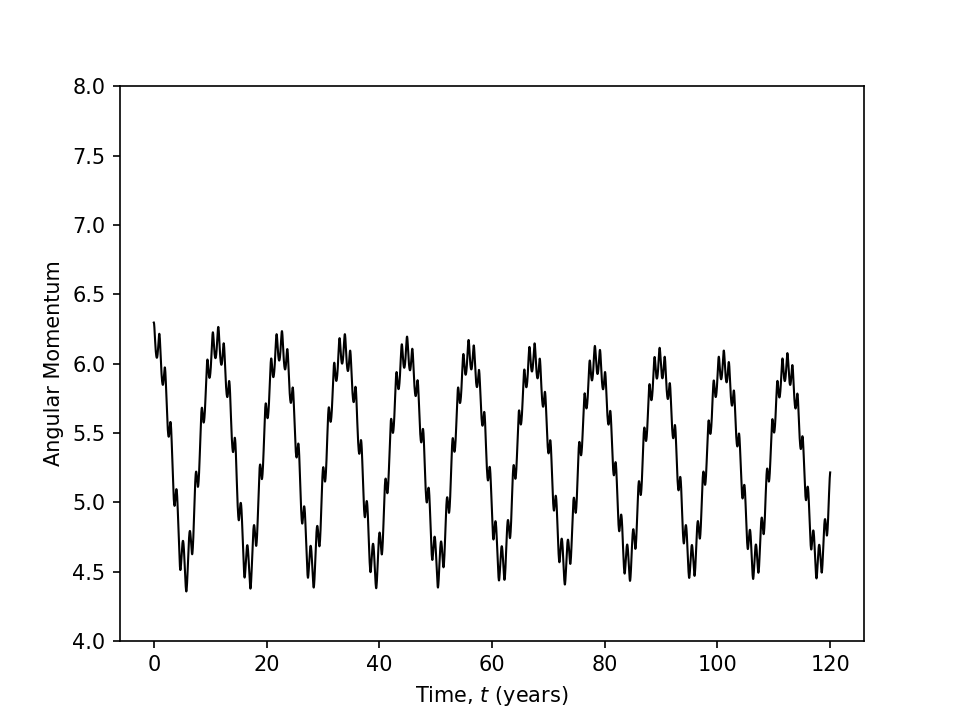

<IPython.core.display.Javascript object>


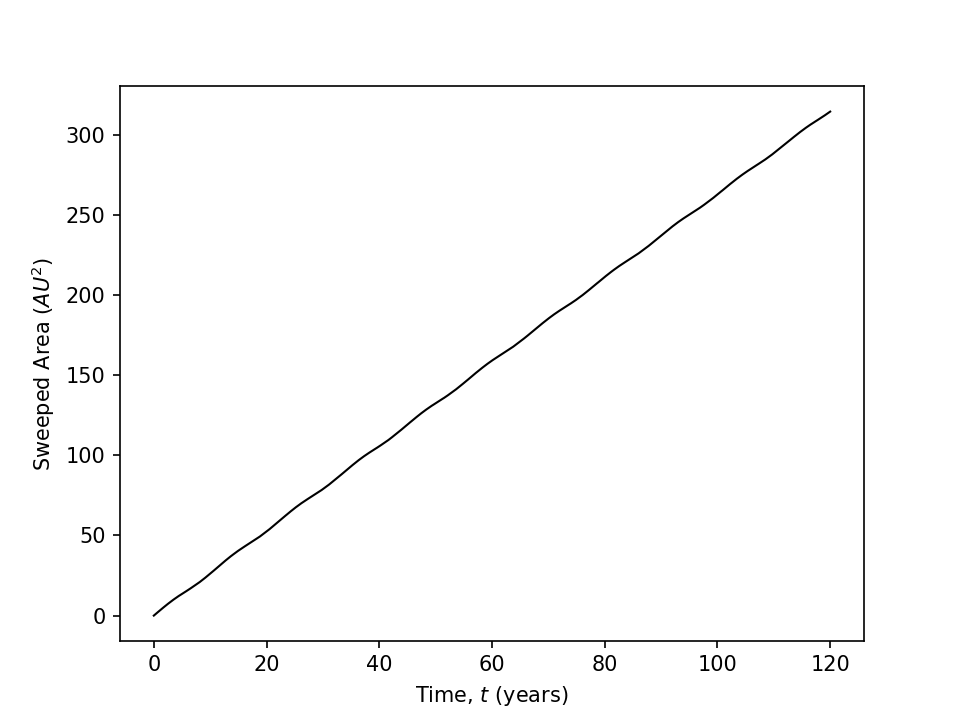

In [8]:

lbl = 'orbit'
py.plot(0,0,'ro',linewidth = 7)
mplot(1,r[:,0],r[:,1],r'$x$ position (AU)',r'$y$ position (AU)','blue','Earth')
mplot(1,rj[:,0],rj[:,1],r'$x$ position (AU)',r'$y$ position (AU)','green','Super Jupiter')
py.ylim([-9, 9])

py.axis('equal')
mplot(2,t,KE,r'Time, $t$ (years)',r'Kinetice Energy, $KE$ ($\times$'+str("%.*e"%(2, EE))+' Joule)','blue','KE')
mplot(2,t,PE,r'Time, $t$ (years)',r'Potential Energy, $KE$ ($\times$'+str("%.*e"%(2, EE))+' Joule)','red','PE')
mplot(2,t,KE+PE,r'Time, $t$ (years)',r'Total Energy, $KE$ ($\times$'+str("%.*e"%(2, EE))+' Joule)','black','Total Energy')
q=py.legend(loc = 0)
q.draw_frame(False)
py.ylim([-180, 180])


mplot(3,t,AM,r'Time, $t$ (years)',r'Angular Momentum','black',lbl)
py.ylim([4, 8])

mplot(4,t,AreaVal,r'Time, $t$ (years)',r'Sweeped Area ($AU^2$)','black',lbl)

In [9]:
# Animation function. Reads out the positon coordinates sequentially
def animate(i):
    earth_trail = 40;
    jupiter_trail = 200;
    tm_yr = 'Elapsed time = ' + str(round(t[i],1)) + ' years'
    ttl.set_text(tm_yr)
    line1.set_data(r[i:max(1,i-earth_trail):-1,0], r[i:max(1,i-earth_trail):-1,1])
    line2.set_data(rj[i:max(1,i-jupiter_trail):-1,0], rj[i:max(1,i-jupiter_trail):-1,1])
    

    return (line1,line2)


<IPython.core.display.Javascript object>


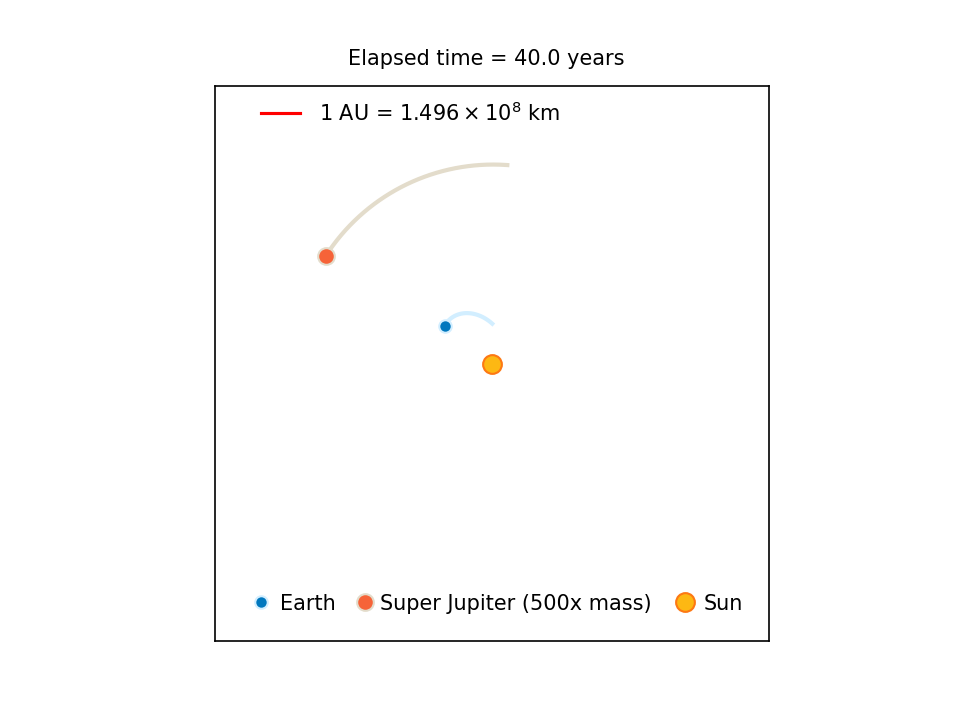

In [10]:
# Function for setting up the animation

fig, ax = py.subplots()
ax.axis('square')
ax.set_xlim(( -7.2, 7.2))
ax.set_ylim((-7.2, 7.2))
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks

ax.plot(0,0,'o',markersize = 9, markerfacecolor = "#FDB813",markeredgecolor ="#FD7813" )
line1, = ax.plot([], [], 'o-',color = '#d2eeff',markevery=10000, markerfacecolor = '#0077BE',lw=2)   # line for Earth
line2, = ax.plot([], [], 'o-',color = '#e3dccb',markersize = 8, markerfacecolor = '#f66338',lw=2,markevery=10000)   # line for Jupiter


ax.plot([-6,-5],[6.5,6.5],'r-')
ax.text(-4.5,6.3,r'1 AU = $1.496 \times 10^8$ km')

ax.plot(-6,-6.2,'o', color = '#d2eeff', markerfacecolor = '#0077BE')
ax.text(-5.5,-6.4,'Earth')

ax.plot(-3.3,-6.2,'o', color = '#e3dccb',markersize = 8, markerfacecolor = '#f66338')
ax.text(-2.9,-6.4,'Super Jupiter (500x mass)')

ax.plot(5,-6.2,'o', markersize = 9, markerfacecolor = "#FDB813",markeredgecolor ="#FD7813")
ax.text(5.5,-6.4,'Sun')
ttl = ax.text(0.24, 1.05, '', transform = ax.transAxes, va='center')
#plt.title('Elapsed time, T=%i years' %u)    

In [11]:
# Call animation function

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=4000, interval=5, blit=True)

In [12]:
HTML(anim.to_html5_video())

In [13]:
# Enable the following line if you want to save the animation to file.

#anim.save('orbit.mp4', fps=30,dpi = 500, extra_args=['-vcodec', 'libx264'])
